In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from patsy import dmatrices,NAAction
from scipy import stats
import warnings
import matplotlib.pyplot as plt
from tabulate import tabulate

In [8]:
your_directory = ''+'/replication'

In [9]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
df = pd.read_stata(your_directory+'/combined.dta')

In [11]:
df0 = pd.read_stata(your_directory+'/india_waters_cityyear.dta')

In [12]:
df3 = pd.read_stata(your_directory+'/im_air.dta')

### Data Summary

In [13]:
df.shape

(2940, 132)

In [14]:
#df['year'].value_counts()

In [15]:
df['year'].max()

2007.0

In [16]:
df['year'].min()

1987.0

In [17]:
#df['city'].value_counts()

In [18]:
 df['e_spm_mean'].mean()

223.23355102539062

In [19]:
 df['e_so2_mean'].mean()

17.258581161499023

In [20]:
 df['e_no2_mean'].mean()

26.819961547851562

In [21]:
 df['e_spm_mean'].max()

838.4285888671875

In [22]:
 df['e_spm_mean'].min()

9.0

In [23]:
len(df[df['actionplan_sc'] == 1]['city'].value_counts())

17

In [24]:
len(df[df['catconverter'] == 1]['city'].value_counts())

31

In [25]:
y_spm_mean = df.groupby('year')['e_spm_mean'].mean()
y_so2_mean = df.groupby('year')['e_so2_mean'].mean()
y_no2_mean = df.groupby('year')['e_no2_mean'].mean()

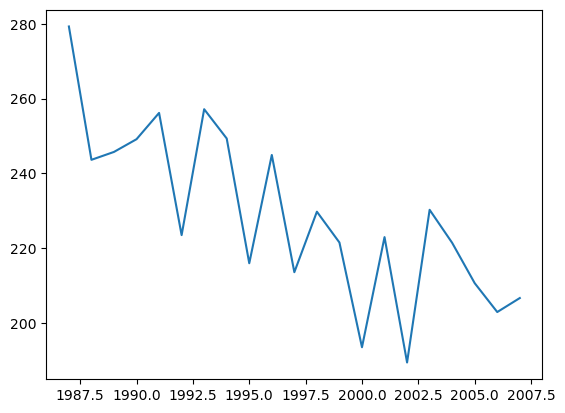

In [26]:
plt.plot(y_spm_mean)

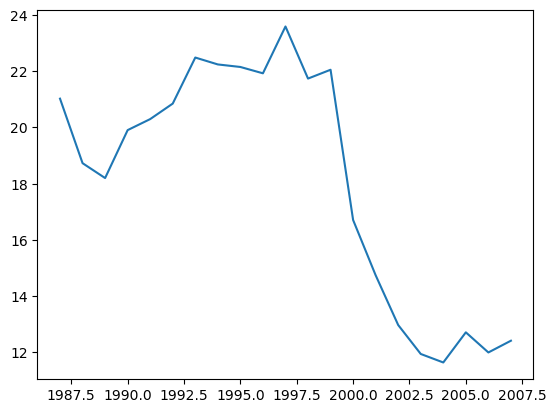

In [27]:
plt.plot(y_so2_mean)

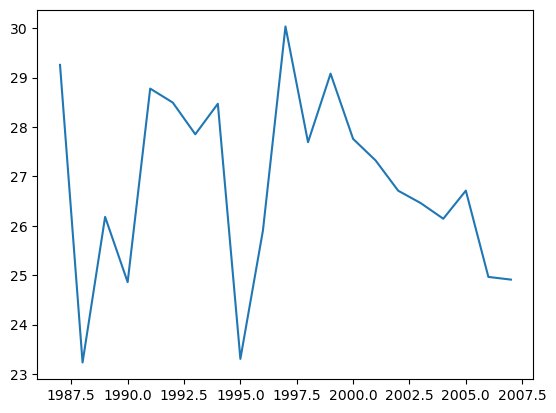

In [28]:
plt.plot(y_no2_mean)

In [29]:
df0.shape

(6163, 124)

In [30]:
#df0['year'].value_counts()

In [31]:
df0['year'].max()

2007.0

In [32]:
df0['year'].min()

1986.0

In [33]:
#df0['city'].value_counts()

In [34]:
#df0['river'].value_counts()

In [35]:
sum(df0['city'].value_counts())

6163

In [36]:
df0['bod'].mean()

4.155832261362016

In [37]:
df0['do'].mean()

7.133985104207769

In [38]:
df0['lnfcoli'].mean()

5.425857067108154

In [39]:
#for i in ['yap1', 'gap1', 'gap2', 'nrcp', 'dap', 'gomtiap1']:
#    print(len(df0[df0[i] == 1]['city'].value_counts()))

In [40]:
bod     = df0.groupby('year')['bod'].mean()
do      = df0.groupby('year')['do'].mean()
lnfcoli = df0.groupby('year')['lnfcoli'].mean()

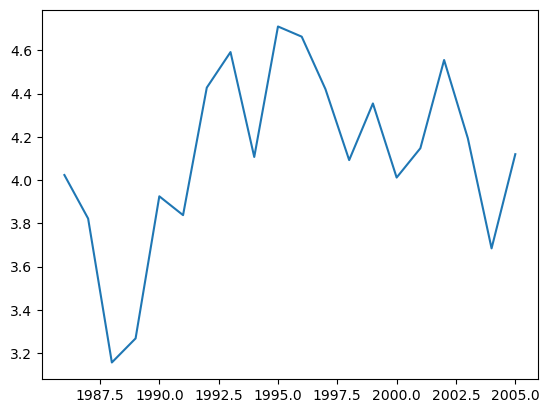

In [41]:
plt.plot(bod)

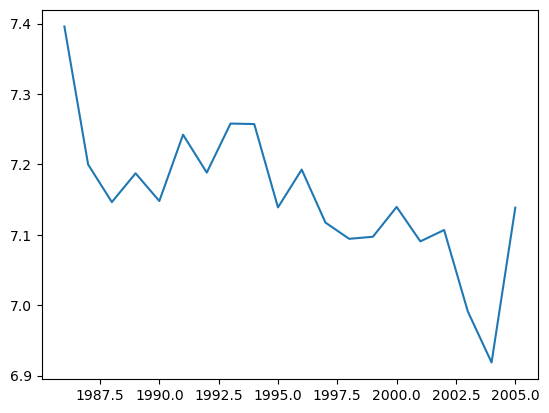

In [42]:
plt.plot(do)

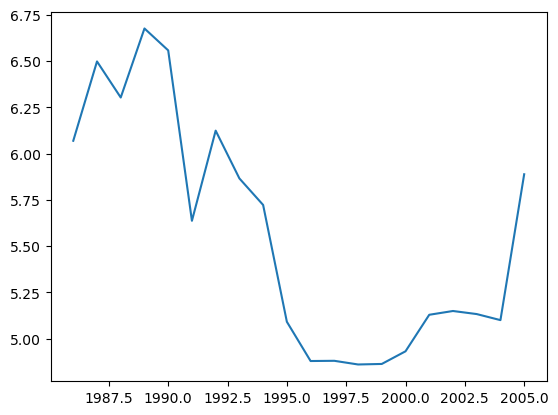

In [43]:
plt.plot(lnfcoli)

In [44]:
df3.shape

(2331, 30)

In [45]:
#df3['city'].value_counts()

In [46]:
#df3['year'].value_counts()

In [47]:
df3['year'].min()

1987.0

In [48]:
df3['year'].max()

2007.0

In [49]:
c_IM     = df3.groupby('year')['c_IM'].mean()

In [50]:
df3['c_IM'].mean()

23.462129592895508

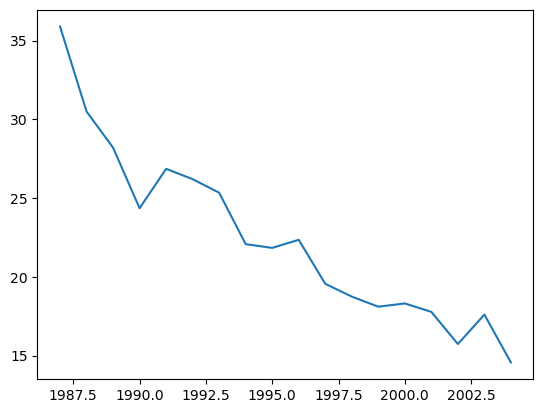

In [51]:
plt.plot(c_IM)

### 2nd Step Model
#### One should first run the 1st Step Model

In [52]:
# A vaild formula should be in this form:
formula = 'taub ~ high + catconv + catconv_high + tauCAT + tauCAT_high + catconv_trend + catconv_high_trend'

In [53]:
# For Equ 2A
#def get_params_cov(result,variables,variable_name):
#    b   = result.params
#    x1  = result.params[variables.index(variable_name)+1]
#    res = result.get_robustcov_results()
#    se  = res.bse
#    p   = res.pvalues
#    return b, se, p, x1

This function is used to estimate the Equ 2C in the origional paper

In [54]:
def get_params_cov(result,variables,variable_name):
    b   = result.params
    x1  = result.params[variables.index(variable_name)+1]
    x2  = result.params[variables.index(variable_name+"_trend")+1]
    res = result.get_robustcov_results()
    se  = res.bse
    p   = res.pvalues
    cov1= res.cov_params()[variables.index(variable_name)+1,variables.index(variable_name)+1]
    cov2= res.cov_params()[variables.index(variable_name+"_trend")+1,variables.index(variable_name+"_trend")+1]
    cov3= res.cov_params()[variables.index(variable_name)+1,variables.index(variable_name+"_trend")+1]
    return b, se, p, x1, x2, cov1, cov2, cov3

def df11(polluants,variables,betas,se,p_values,table_name):
    df = pd.DataFrame(columns=['Pollutant', 'Variable','β (Beta)', 'Robust-standard error', 'p-value'])
    for i in range(len(polluants)):
        for j in range(len(betas[i])):
            df = df.append({'Pollutant': polluants[i], 'Variable':variables[j],'β (Beta)': round(betas[i][j],5), 'Robust-standard error': round(se[i][j],5), 'p-value': round(p_values[i][j],5)}, ignore_index=True)
    print(tabulate(df,df.columns,showindex=False, tablefmt="rst"))
    df.to_csv(your_directory+f'/{table_name}.csv')

def stage2(obj,formula,polluants,typ,r,y_effect,table_name):
    temp = {}
    betas = []
    std_err= []
    p_values= []
    endog    = formula.split(" ~ ")[0]
    variables = formula.split(" ~ ")[1].split(" + ")
    polluant_s= [obj['params'][pollutant][typ] for pollutant in polluants]
    window    = len(polluant_s[0])
    temp['tau'+typ] = np.array([i for i in np.arange(r-window/2+1,r+1) for _ in range(2)]) if 'catconv_high' in variables else np.arange(r-window+1,r+1)
    for var in variables:
        if 'trend' not in var and 'high' not in var and 'tau' not in var:
            v         = var
            temp[v] = temp['tau'+typ] >=0
            temp[v+'_trend'] = temp['tau'+typ] * temp[v]
            temp[v+'_trend'] = np.where(temp['tau'+typ]>=0, temp[v+'_trend']+1, temp[v+'_trend'])
    temp[v]         = np.array([int(i) for i in temp[v]])
    temp['high']    = [1,0] * int(window/2) if 'catconv_high' in variables else [1,0] * window
    if v + '_high' in variables:
        temp['tau'+typ+'_high']    = temp['tau'+typ] * temp['high']
        temp[v + '_high']       = temp[v] * temp['high']
        temp[v + '_high_trend'] = temp[v] * temp['high'] * temp['tau' + typ]
        temp[v + '_high_trend']  = np.where(temp['tau'+typ]>=0,temp[v + '_high_trend']+1,temp[v + '_high_trend'])
    for polluant in np.arange(len(polluants)):
        x = temp[v]
        temp[f'{endog}'] = np.array(obj['params'][polluants[polluant]][typ])
        weights= list(1/np.array(obj['se'][polluants[polluant]][typ]))
        for var in [k for k in variables if k != v]:
            x  = np.column_stack((x, temp[f'{var}']))
        X      = sm.add_constant(x)
        y      = obj['params'][polluants[polluant]][typ]
        #The second steop estimation. 
        model  = sm.WLS(y, X, weights=weights)
        result = model.fit(cov_type='HC3')
        if v+'_high' in variables:
            b, t, p, x1, x2, cov1, cov2, cov3 = get_params_cov(result,variables,"catconv_high")
        else:
            b, t, p, x1, x2, cov1, cov2, cov3 = get_params_cov(result,variables,v)
#        b, t, p, x1 = get_params_cov(result,variables,v)
        parmas_5y = x1 + y_effect * x2
        se_5y     = np.sqrt(cov1 + y_effect ** 2 * cov2 + 2 * y_effect * cov3)
        t_stat    = parmas_5y / se_5y
        df      = result.df_resid
        p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df))
        betas.append(list(b[1:])+[parmas_5y])
        std_err.append(list(t[1:])+[t_stat])
        p_values.append(list(p[1:])+[p_value])
    variables+=['5-year effect']
    
    return df11(polluants,variables,betas,std_err,p_values,table_name)


### 2nd Step Estimates

Variables Description: <br>
For Eqn 2C in the original paper: $\hat{\sigma}_\tau=\pi_{0}+\pi_{1}(Policy)_\tau+\pi_{2}\tau+\pi_{3}(1(Policy)_\tau \times \tau)+\epsilon_\tau$,<br>
We have,<br>
SCAP / CAT / NRCP: $1(Policy)_\tau$ <br>
tauSC / tauCAT / tau: $\tau$ <br>
scap_trend / catconv_trend:  $(1(Policy)_\tau \times \tau)$

Function Description: <br>

stage2(1,2,3,4,5,6,7) <br>

1: The 1st step estimation <br>
2: A formula <br>
3: Types of the pollutant(s) <br>
4: Number of the policy <br>
5: Left window (Selectd years of post-treatment) <br>
6: Number of years treatment effect (We use 5 years here) <br>
7: Name of the output <br>

#### Air Pollution
##### SCAP

In [64]:
formula = 'taub ~ scap + tauSC + scap_trend'
stage2(results,formula,['spm','so2','no2'],'SC',3,5,'table10a')

===========  =============  ==========  =======================  =========
Pollutant    Variable         β (Beta)    Robust-standard error    p-value
===========  =============  ==========  =======================  =========
spm          scap              7.06179                 11.606      0.54288
spm          tauSC            -3.58315                  3.13774    0.25347
spm          scap_trend       -1.30876                  5.7577     0.82019
spm          5-year effect     0.51799                  0.01974    0.9848
so2          scap             -1.45907                  0.41569    0.00045
so2          tauSC             0.19451                  0.07703    0.01157
so2          scap_trend       -0.04524                  0.22604    0.84137
so2          5-year effect    -1.68527                 -1.8519     0.10647
no2          scap             -1.63428                  2.4798     0.50987
no2          tauSC             1.3969                   0.45983    0.00238
no2          scap_trend   

##### CAT

In [65]:
formula = 'taub ~ catconv + tauCAT + catconv_trend'
stage2(results,formula,['spm','so2','no2'],'CAT',9,5,'table10b')

===========  =============  ==========  =======================  =========
Pollutant    Variable         β (Beta)    Robust-standard error    p-value
===========  =============  ==========  =======================  =========
spm          catconv           6.78839                 11.2509     0.54627
spm          tauCAT            7.70971                  2.38803    0.00124
spm          catconv_trend   -10.9929                   2.78265    8e-05
spm          5-year effect   -48.1763                  -3.03472    0.00958
so2          catconv          -0.59419                  1.45225    0.68243
so2          tauCAT            2.00151                  0.27182    0
so2          catconv_trend    -2.53759                  0.32573    0
so2          5-year effect   -13.2821                  -6.92114    1e-05
no2          catconv           3.05015                  1.76017    0.08312
no2          tauCAT            0.8816                   0.42015    0.03588
no2          catconv_trend    -1.52059   

#### Water pollution

In [66]:
formula = 'taub ~ nrcp + tau + nrcp_trend'
stage2(results_2,formula,['bod','do','lnfcoli'],'',10,5,'table3finalb')

===========  =============  ==========  =======================  =========
Pollutant    Variable         β (Beta)    Robust-standard error    p-value
===========  =============  ==========  =======================  =========
bod          nrcp              1.04747                  1.25047    0.40222
bod          tau              -0.88324                  0.39238    0.02439
bod          nrcp_trend        0.96271                  0.41282    0.0197
bod          5-year effect     5.86103                  2.19905    0.04518
do           nrcp              0.11168                  0.14227    0.43245
do           tau               0.09674                  0.03186    0.00239
do           nrcp_trend       -0.14882                  0.03389    1e-05
do           5-year effect    -0.63244                 -2.24523    0.04142
lnfcoli      nrcp              0.17714                  0.50248    0.72444
lnfcoli      tau              -0.09857                  0.0869     0.25665
lnfcoli      nrcp_trend     

#### Structural Break Test Result

In [67]:
print(tabulate(df1000,df1000.columns,showindex=False, tablefmt="rst"))
df1000.to_csv(your_directory+'sbt_mor.csv')

===========  ===  =======  =========
Pollutant      т        F    p-value
===========  ===  =======  =========
spm            2  4.98934    0.0437
so2           -1  4.22056    0.06061
no2           -2  2.57683    0.13245
bod           -2  2.54411    0.13303
do            -2  3.95812    0.06655
lnfcoli       -2  6.2397     0.02557
===========  ===  =======  =========


#### Infant Mortality

In [68]:
formula = 'IMR ~ catconv + tauCAT + catconv_trend'
stage2(results_4,formula,['IM'],'CAT',5,5,'table_6_mor')

===========  =============  ==========  =======================  =========
Pollutant    Variable         β (Beta)    Robust-standard error    p-value
===========  =============  ==========  =======================  =========
IM           catconv           3.56181                  1.37325    0.00949
IM           tauCAT           -0.19602                  0.11594    0.0909
IM           catconv_trend    -0.95955                  0.34345    0.00521
IM           5-year effect    -1.23595                 -0.88393    0.3941
===========  =============  ==========  =======================  =========


#### Difference in Catalytic Converter Five-year Treatment Effect between Cities above and below the Median in Proxies for Demand for Clean Air

In [69]:
formula = 'taub ~ high + catconv + catconv_high + tauCAT + tauCAT_high + catconv_trend + catconv_high_trend'
stage2(results_5,formula,['spm','so2','no2'],'CAT',9,5,'table_7_mor')

===========  ==================  ==========  =======================  =========
Pollutant    Variable              β (Beta)    Robust-standard error    p-value
===========  ==================  ==========  =======================  =========
spm          high                  -7.70525                 20.8333     0.71149
spm          catconv              -47.8899                  12.3287     0.0001
spm          catconv_high          23.3507                  23.7142     0.32479
spm          tauCAT                 8.06658                  3.39056    0.01735
spm          tauCAT_high           -0.8636                   4.103      0.83329
spm          catconv_trend        -10.4808                   4.51715    0.02033
spm          catconv_high_trend    -1.03942                  5.34095    0.8457
spm          5-year effect         18.1536                   0.53955    0.5941
so2          high                  -0.89088                  3.40456    0.79357
so2          catconv                0.25726

In [70]:
formula = 'taub ~ high + catconv + catconv_high + tauCAT + tauCAT_high + catconv_trend + catconv_high_trend'
stage2(results_6,formula,['spm','so2','no2'],'CAT',9,5,'table7_a_mor')

===========  ==================  ==========  =======================  =========
Pollutant    Variable              β (Beta)    Robust-standard error    p-value
===========  ==================  ==========  =======================  =========
spm          high                  26.9105                  20.905      0.198
spm          catconv               34.5474                  10.7895     0.00136
spm          catconv_high         -25.6593                  23.5943     0.27681
spm          tauCAT                 3.46719                  2.54291    0.17273
spm          tauCAT_high            3.58061                  3.44257    0.29829
spm          catconv_trend         -6.18509                  4.17626    0.1386
spm          catconv_high_trend    -3.49949                  4.96417    0.48084
spm          5-year effect        -43.1567                  -1.47652    0.15182
so2          high                  11.9953                   3.486      0.00058
so2          catconv               21.6017 

In [71]:
formula = 'taub ~ high + catconv + catconv_high + tauCAT + tauCAT_high + catconv_trend + catconv_high_trend'
stage2(results_7,formula,['spm','so2','no2'],'CAT',9,5,'table_8_mor')

===========  ==================  ==========  =======================  =========
Pollutant    Variable              β (Beta)    Robust-standard error    p-value
===========  ==================  ==========  =======================  =========
spm          high                   6.89449                 15.2675     0.65157
spm          catconv              -17.7246                  13.4253     0.18675
spm          catconv_high         -16.1164                  22.1884     0.46763
spm          tauCAT                 2.70699                  1.94754    0.16454
spm          tauCAT_high            8.59352                  4.16904    0.03928
spm          catconv_trend         -6.73742                  2.96284    0.02297
spm          catconv_high_trend    -4.60364                  5.15693    0.37201
spm          5-year effect        -39.1346                  -1.16224    0.2557
so2          high                  -0.48606                  2.36204    0.83696
so2          catconv               -5.795

### 1st Step Model

#### Air Pollution

In [56]:
right_windows = 5 #This line indicates the left window we use for the placebo test
results = {'params':{},'se':{}}
for i in ['spm','so2','no2']:
    df1 = df.copy()
    df1['tempsc'] = np.where(df1['actionplan_sc'] == 1, df1['year'], np.nan)
    df1['tempsc'] = df1.groupby('city')['tempsc'].transform('min') 
    df1['tempcat']= np.where(df1['catconverter'] == 1, df1['year'], np.nan)
    df1['tempcat']= df1.groupby('city')['tempcat'].transform('min')
    df1['neveradoptCAT'] = np.where(df1['tempcat'].isna(),1,0)
    df1['temp']     = df1.groupby('city')['year'].transform('min') 
    df1['tausc'] = np.where((df1['tempsc'] > df1['temp']) & (df1[f'e_{i}_mean'].notna()), df1['year'] - df1['tempsc'], np.nan)
    df1['taucat']= np.where((df1['tempcat']> df1['temp']) & (df1[f'e_{i}_mean'].notna()), df1['year'] - df1['tempcat'], np.nan)
############################################################################################################
#robustness check                                                                                          #
#    df1['temp_tau'] = df1['taucat'].where((df1['actionplan_sc'] == 0) &(df1[f'taucat']==0))               #
#    df1['tau_shifted'] = df1.groupby('city')['temp_tau'].shift(right_windows+1)                           #
#    df1['taucat'] = df1['taucat'] + right_windows+1                                                       #
#    df1['tau_shifted'].fillna(df1['taucat'], inplace=True)                                                #
#    df1['taucat'] = df1['tau_shifted'].copy()                                                             #
############################################################################################################    
    df1['tempx'] = np.where((df1['catconverter'] == 1) & (df1[f'e_{i}_mean'].notna()), 1, np.nan) 
    df1['tempy'] = df1[df1['tempcat'].notna()].groupby('city')['tempx'].transform('min')
    df1['neveradoptCAT'] = np.where((df1['tempy'].notna()) & (df1['tempcat'].isna()), 1, df1['neveradoptCAT'])
    df1['taucat'] = np.where((df1['tempy'].notna()) & (df1['tempcat'].isna()), np.nan, df1['taucat'])
    
    df1['temp1'] = df1.groupby('city')['tausc'].transform('max')
    df1['temp2'] = df1.groupby('city')['tausc'].transform('min')
    df1['temp3'] = df1.groupby('city')['taucat'].transform('max')
    df1['temp4'] = df1.groupby('city')['taucat'].transform('min')
    df1['cts'] = df1.groupby('city')[f'e_{i}_mean'].transform('count')
    df1['useSC'] = (((df1['temp1'] >= 3) & (df1['temp2'] <= -3) & (df1['cts'] > 1))|(( df1['tempsc'].isna()) & (df1['cts'] > 1)))
    df1['useCAT']= (((df1['temp3'] >= 3) & (df1['temp4'] <= -3) & (df1['cts'] > 1))|(( df1['tempcat'].isna()) & (df1['cts'] > 1)))
    df1 = df1[(df1['useCAT'] != 0)&(df1['useSC'] != 0)]
    D_sc_vars  = []
    D_cat_vars = []
    for t in np.arange(-7,0):
        df1[f'taum{abs(t)}sc']  = (df1['tausc'] == t)
        D_sc_vars += [f'taum{abs(t)}sc']
    for t in np.arange(0,4):
        df1[f'tau{t}sc']  = (df1['tausc'] == t)
        D_sc_vars += [f'tau{t}sc']
    for t in np.arange(-7,0): #Change the left number to -right_windows to perform a placebo test
        df1[f'taum{abs(t)}'] = (df1['taucat'] == t)
        D_cat_vars+= [f'taum{abs(t)}']
    for t in np.arange(0,10): #Change the right number to right_windows+1 to perform a placebo test
        df1[f'tau{t}cat'] = (df1['taucat'] == t)
        D_cat_vars+= [f'tau{t}cat']
    df1['tauSCL']  = np.where(df1[f'tausc'] < -7, 1, 0)
    df1['tauSCR']  = np.where((df1[f'tausc'] > 3), 1, 0)
    df1['tauCATL'] = np.where(df1[f'taucat'] < -7, 1, 0) #Change the first number to -right_windows to perform a placebo test
    df1['tauCATR'] = np.where(df1[f'taucat'] > 9, 1, 0) #Change the first number to right_windows to perform a placebo test
    D_sc_str  = ' + '.join(D_sc_vars)
    D_cat_str = ' + '.join(D_cat_vars)
    weights   = df1['pop_urban']
    na_action = NAAction('drop')
    formula   = f"e_{i}_mean ~ {D_sc_str} + {D_cat_str}  + tauSCL + tauSCR + tauCATL + tauCATR + lit_urban + mean + C(city) + C(year)"
    y, X    = dmatrices(formula, data=df1, return_type='dataframe', NA_action = na_action)
    weights = weights[X.index]
    model   = sm.WLS(y, X, weights=weights)
    result  = model.fit()    
    results['params'][i]        = {'SC':{},'CAT':{}}
    results['params'][i]['SC']  = [result.params[sigma + '[T.True]'] for sigma in D_sc_vars]
    results['params'][i]['CAT'] = [result.params[sigma + '[T.True]'] for sigma in D_cat_vars]
    results['se'][i]            = {'SC':{},'CAT':{}}
    results['se'][i]['SC']      = [result.bse[sigma + '[T.True]'] for sigma in D_sc_vars]
    results['se'][i]['CAT']     = [result.bse[sigma + '[T.True]'] for sigma in D_cat_vars]

#### Water Quality

In [57]:
df2=df0.copy()
results_2 = {'params':{},'se':{}}
df2['city_river'] = pd.factorize(df2['city'] + df2['river'])[0]
for i in ['bod','do','lnfcoli']:
    for j in ['yap1', 'gap1', 'gap2', 'nrcp', 'dap', 'gomtiap1']:
        df2[f'{j}_city'] = df2.groupby(['city_river'])[j].transform('max')
    df2['temp2'] = np.where(df2['nrcp_city'] == 1, 1995, np.nan)
    df2['temp2'] = np.where((df2['yap1_city'] == 1) | (df2['gap2_city'] == 1) | (df2['dap_city'] == 1) | (df2['gomtiap1_city'] == 1), 1993,df2['temp2'])
    df2['temp2'] = np.where(df2['gap1_city']  == 1, 1985,df2['temp2'])
    df2['temp3'] = df2.groupby('city_river')['year'].transform('min')
    df2['tau']   = np.where((df2['temp2'] > df2['temp3']) & (df2[i].notna()), df2['year'] - df2['temp2'], np.nan)
    df2['neveradopt'] = np.where(df2['temp2'].isna(), 1, 0)
    df2['tempx'] = np.where((df2[['yap1', 'gap1', 'gap2', 'nrcp', 'dap', 'gomtiap1']].sum(axis=1) > 0) & df2[i].notna(), 1, np.nan)
    df2['tempy'] = df2.groupby('city_river')['tempx'].transform('min')
    df2['temp4'] = df2.groupby('city_river')['tau'].transform('max')
    df2['temp5'] = df2.groupby('city_river')['tau'].transform('min')

    df2['cts'] = df2.groupby(['city'])[i].transform('count')
    df2['use'] = np.where(((df2['temp4'] >= 3) & (df2['temp5'] <= -3)) | ((df2['neveradopt'] == 1) & (df2['cts'] > 1)), 1, 0)
    df2 = df2[df2['use'] == 1]
    df2 = df2[df2[i].notnull()]
    D_vars = []
    for t in range(-7, 0):
        df2[f'taum{abs(t)}'] = (df2['tau'] == t)
        D_vars += [f'taum{abs(t)}']
    for t in range(0, 11):
        df2[f'tau{t}'] = (df2['tau'] == t)
        D_vars += [f'tau{t}']
    
    df2['tauL']  = np.where(df2[f'tau'] < -7, 1, 0)
    df2['tauR']  = np.where((df2[f'tau'] > 10) & (df2[f'tau'].notna()), 1, 0)
    D_str  = ' + '.join(D_vars)
    weights   = df2['pop_urban']
    na_action = NAAction('drop')

    formula   = f"{i} ~ {D_str} + tauL + tauR + lit_urban + pce + C(city_river) + C(year)"
    y, X    = dmatrices(formula, data=df2, return_type='dataframe', NA_action = na_action)
    weights = weights[X.index]
    model   = sm.WLS(y, X, weights=weights)
    result  = model.fit()
    results_2['params'][i] = {'':{}}
    results_2['se'][i] = {'':{}}
    results_2['params'][i][''] = [result.params[sigma + '[T.True]'] for sigma in D_vars]
    results_2['se'][i]['']     = [result.bse[sigma + '[T.True]'] for sigma in D_vars]  

#### Assessing Robustness with a Structural Break Test

In [58]:
res100 = {'pollutant':{}}
for i in ['spm','so2','no2']:
    maxF = -9999
    taub = results['params'][i]['CAT']
    tause= results['se'][i]['CAT']
    tau = np.arange(-7,10)
    df100 = pd.DataFrame({"y":taub,"tau":tau,'tause':tause})
    df100.set_index('tau', inplace=True)
    trim = 5  
    lb = df100.index.min() + trim
    ub = df100.index.max() - trim
    T = df100.shape[0]
    Q = np.zeros((T - 2*trim + 1, 3))
    for tt, taus in enumerate(range(lb, ub + 1)):
        df100['breakpoint'] = 0
        df100.loc[df100.index >= taus, 'breakpoint'] = 1
        df100['breaktrend'] = df100['breakpoint'] * df100.index
        df100.loc[df100.index >= taus, 'breaktrend'] += 1
        model = smf.wls('y ~ breakpoint + tau + breaktrend', df100, weights=list(1/np.array(df100['tause']))).fit()
        F = model.f_test([[0, 1, 0,1]])      
        maxF = max(F.fvalue,maxF)
        if maxF == F.fvalue:
            ftau = taus
            minP = F.pvalue
    res100['pollutant'][i] = {}       
    res100['pollutant'][i]['tau'] = ftau
    res100['pollutant'][i]['F']   = round(maxF,5)
    res100['pollutant'][i]['p-value']   = round(minP,5)

for i in ['bod','do','lnfcoli']:
    maxF = -9999
    taub = results_2['params'][i]['']
    tause= results_2['se'][i]['']
    tau = np.arange(-7,11)
    df100 = pd.DataFrame({"y":taub,"tau":tau,'tause':tause})
    df100.set_index('tau', inplace=True)
    trim = 5  
    lb = df100.index.min() + trim
    ub = df100.index.max() - trim
    T = df100.shape[0]
    Q = np.zeros((T - 2*trim + 1, 3))
    for tt, taus in enumerate(range(lb, ub + 1)):
        df100['breakpoint'] = 0
        df100.loc[df100.index >= taus, 'breakpoint'] = 1
        df100['breaktrend'] = df100['breakpoint'] * df100.index
        df100.loc[df100.index >= taus, 'breaktrend'] += 1
        model = smf.wls('y ~ breakpoint + tau + breaktrend', df100, weights=list(1/np.array(df100['tause']))).fit()
        F = model.f_test([[0, 1, 0,1]])
        maxF = max(F.fvalue,maxF)
        if maxF == F.fvalue:
            ftau = taus
            minP = F.pvalue
    res100['pollutant'][i] = {} 
    res100['pollutant'][i]['tau'] = ftau
    res100['pollutant'][i]['F']   = round(maxF,5)
    res100['pollutant'][i]['p-value']   = round(minP,5)

In [59]:
lst = [{'Pollutant': key, 'т': value['tau'], 'F': value['F'], 'p-value': value['p-value']} for key, value in res100['pollutant'].items()]

df1000 = pd.DataFrame(lst)

#### Infant Mortality

In [60]:
results_4 = {'params':{},'se':{}}
df1                = df3.copy()
df1['temp']        = df1.groupby('city')['c_IM'].transform('max')
df1                = df1.loc[df1['temp'].notna()]
df1['year_start']  = df1.groupby('city')['year'].transform('min')
df1['year_end']     = df1.groupby('city')['year'].transform('max')

df1['tau']     = np.where((df1['catyear']>df1['year_start']) & (df1['catyear'].notna()), df1['year'] - df1['catyear'], np.nan)
df1['neveradoptCAT'] = np.where((df1['catyear'].isna())|(df1['year_end']<df1['catyear']),1,0)
#df1['tempx']        = np.where((df1['year']>=df1['catyear']) & (df1['catyear'].notna()) & (df1['c_IM'].notna()),1,np.nan)
#df['tempy'] = np.nan
#df1.loc[df1['catyear'].notna(),'tempy'] = df1.loc[df1['catyear'].notna()].groupby('city')['tempx'].transform('min')
#df1['neveradoptCAT']= np.where((df1['tempy'].isna()) & (df1['catyear'].notna()),1,df1['neveradoptCAT'])
#df1['tau_cat']= np.where((df1['tempy'].isna()) & (df1['catyear'].notna()),np.nan,df1['tau_cat'])
#df1['tau_cat'] = np.where((df1['catyear'].isna()) & (df1['c_IM'].notna()),0,df1['tau_cat'])

df1['temp1']       = df1.groupby('city')['tau'].transform('max')
df1['temp2']       = df1.groupby('city')['tau'].transform('min')
df1['cts']         = df1.groupby('city')['c_IM'].transform('count')
#df1['temp3']       = ((df1['tau_cat'] >= 3) & ((df1['tau_cat'].notna())))
#df1['temp4']       = ((df1['tau_cat'] <= 3) & ((df1['tau_cat'].notna())))
#df1['mtemp3']      = df1.groupby('city')['temp3'].transform('max')
#df1['mtemp4']      = df1.groupby('city')['temp4'].transform('max')

#df1['neveradoptCAT'] = np.where((df1['tempy'].notna()) & (df1['catyear'].isna()), 1, df1['neveradoptCAT'])
#print(sum(df1['neveradoptCAT']==0))

#df1['tau_cat'] = np.where((df1['tempy'].notna()) & (df1['catyear'].isna()), np.nan, df1['tau_cat'])
#print(sum(df1['neveradoptCAT']==0))

df1['useCAT'] = ((df1['temp1'] >= 3) & (df1['temp2'] <= -3) & (df1['cts'] > 1)) | ((df1['neveradoptCAT'] == 1) & (df1['cts'] > 1))
#print(sum(df1['neveradoptCAT']==0))

df1 = df1[df1['useCAT'] != 0]

df1 = df1[df1['c_IM'].notna()]
D_cat_vars = []
for t in np.arange(-10,0):
    df1[f'D_neg{abs(t)}_cat'] = (df1['tau'] == t)
    D_cat_vars = D_cat_vars + [f'D_neg{abs(t)}_cat']
for t in np.arange(0,6):
    df1[f'D_{t}_cat'] = (df1['tau'] == t)
    D_cat_vars+= [f'D_{t}_cat']
df1['tauCATL'] = np.where(df1['tau'] < -10, 1, 0)
df1['tauCATR'] = np.where(df1['tau'] > 5, 1, 0)

D_cat_str = ' + '.join(D_cat_vars)

weights   = df1['c_birth']
na_action = NAAction('drop')
formula   = f"c_IM ~ {D_cat_str} + tauCATL + tauCATR + lit_urban + mean + C(city) + C(year)"

y, X    = dmatrices(formula, data=df1, return_type='dataframe', NA_action = na_action)
weights = weights[X.index]
model   = sm.WLS(y, X, weights=weights)
result  = model.fit()
results_4['params']['IM']        = {'SC':{},'CAT':{}}
results_4['params']['IM']['CAT'] = [result.params[sigma + '[T.True]'] for sigma in D_cat_vars]
results_4['se']['IM']            = {'SC':{},'CAT':{}}
results_4['se']['IM']['CAT']     = [result.bse[sigma + '[T.True]'] for sigma in D_cat_vars]

#### Why Were the Air Pollution Policies More Effective than the Water Pollution Policies?

In [61]:
results_5 = {'params':{},'se':{}}

for i in ['spm','so2','no2']:
    df1 = df.copy()
    df1['policyadoption'] = df1.groupby(['state', 'city'])['catconverter'].transform('max')
    df1['urban_lit_percapita'] = df1['lit_urban'] / df1['pop_urban']
    df1['lit'] = np.where((df1['year'] == 1987) & (df1['policyadoption'] == 1),df1['urban_lit_percapita'],np.nan)
    df1.sort_values(['city', 'lit'], inplace=True)
    df1['lit'] = df1.groupby('city')['lit'].ffill()
    #Find the median expenditure
    median     = df1['lit'].median()
    #find the observation with expenditure above the median 
    df1['lit_upper'] = np.where((df1['lit'] > df1['lit'].median()) & (df1['policyadoption']==1), 1, np.nan) 
    df1['lit_upper'] = np.where((df1['lit'] <= median) & (df1['policyadoption']==1), 0, df1['lit_upper']) 
    df1 = df1.sort_values(by=['state', 'city', 'year'])
    df1['start_sc'] = np.where(df1['actionplan_sc'] == 1, df1['year'], np.nan)
    df1['start_sc'] = df1.groupby('city')['start_sc'].transform('min') 
    df1['start_cat']= np.where(df1['catconverter'] == 1, df1['year'], np.nan)
    df1['start_cat']= df1.groupby('city')['start_cat'].transform('min')
    df1['temp']     = df1.groupby('city')['year'].transform('min') 
    df1[f'tau_{i}_sc'] = np.where((df1['start_sc'] > df1['temp']) & (df1[f'e_{i}_mean'].notna()), df1['year'] - df1['start_sc'], np.nan)
    df1[f'tau_{i}_cat']= np.where((df1['start_cat']> df1['temp']) & (df1[f'e_{i}_mean'].notna()), df1['year'] - df1['start_cat'], np.nan)

    df1['temp1'] = df1.groupby('city')[f'tau_{i}_sc'].transform('max')
    df1['temp2'] = df1.groupby('city')[f'tau_{i}_sc'].transform('min')
    df1['temp3'] = df1.groupby('city')[f'tau_{i}_cat'].transform('max')
    df1['temp4'] = df1.groupby('city')[f'tau_{i}_cat'].transform('min')
    df1['cts'] = df1.groupby('city')[f'e_{i}_mean'].transform('count')
    useSC = (((df1['temp1'] >= 3) & (df1['temp2'] <= -3) & (df1['cts'] > 1))|(( df1['start_sc'].isna()) & (df1['cts'] > 1)))
    useCAT= (((df1['temp3'] >= 3) & (df1['temp4'] <= -3) & (df1['cts'] > 1))|(( df1['start_cat'].isna()) & (df1['cts'] > 1)))

    df1   = df1.loc[useSC & useCAT]
    df1   = df1.loc[df1[f'e_{i}_mean'].notna()]    

    D_sc_vars  = []
    D_cat_vars = []
    for t in np.arange(-7,0):
        df1[f'D_neg{abs(t)}_{i}_sc_upper']  = ((df1[f'tau_{i}_sc'] == t) & (df1['lit_upper'] == 1))
        df1[f'D_neg{abs(t)}_{i}_sc_lower']  = ((df1[f'tau_{i}_sc'] == t) & (df1['lit_upper'] == 0))
        D_sc_vars += [f'D_neg{abs(t)}_{i}_sc_upper'] + [f'D_neg{abs(t)}_{i}_sc_lower']
    for t in np.arange(0,4):
        df1[f'D_{t}_{i}_sc_upper']  = ((df1[f'tau_{i}_sc'] == t) & (df1['lit_upper'] == 1))
        df1[f'D_{t}_{i}_sc_lower']  = ((df1[f'tau_{i}_sc'] == t) & (df1['lit_upper'] == 0))
        D_sc_vars += [f'D_{t}_{i}_sc_upper'] + [f'D_{t}_{i}_sc_lower']
    for t in np.arange(-7,0):
        df1[f'D_neg{abs(t)}_{i}_cat_upper'] = ((df1[f'tau_{i}_cat'] == t) & (df1['lit_upper'] == 1))
        df1[f'D_neg{abs(t)}_{i}_cat_lower'] = ((df1[f'tau_{i}_cat'] == t) & (df1['lit_upper'] == 0))
        D_cat_vars+= [f'D_neg{abs(t)}_{i}_cat_upper'] + [f'D_neg{abs(t)}_{i}_cat_lower']
    for t in np.arange(0,10):
        df1[f'D_{t}_{i}_cat_upper'] = ((df1[f'tau_{i}_cat'] == t) & (df1['lit_upper'] == 1))
        df1[f'D_{t}_{i}_cat_lower'] = ((df1[f'tau_{i}_cat'] == t) & (df1['lit_upper'] == 0))
        D_cat_vars+= [f'D_{t}_{i}_cat_upper'] + [f'D_{t}_{i}_cat_lower']
    df1['tauSCL_upper']  = np.where((df1[f'tau_{i}_sc'] < -7) & (df1['lit_upper'] == 1), 1, 0)
    df1['tauSCL_lower']  = np.where((df1[f'tau_{i}_sc'] < -7) & (df1['lit_upper'] == 0), 1, 0)
    df1['tauSCR_upper']  = np.where((df1[f'tau_{i}_sc'] > 3)  & (df1['lit_upper'] == 1), 1, 0)
    df1['tauSCR_lower']  = np.where((df1[f'tau_{i}_sc'] > 3)  & (df1['lit_upper'] == 0), 1, 0)
    df1['tauCATL_upper'] = np.where((df1[f'tau_{i}_cat'] < -7)& (df1['lit_upper'] == 1), 1, 0)
    df1['tauCATL_lower'] = np.where((df1[f'tau_{i}_cat'] < -7)& (df1['lit_upper'] == 0), 1, 0)
    df1['tauCATR_upper'] = np.where((df1[f'tau_{i}_cat'] > 9) & (df1['lit_upper'] == 1), 1, 0)
    df1['tauCATR_lower'] = np.where((df1[f'tau_{i}_cat'] > 9) & (df1['lit_upper'] == 0), 1, 0)
    D_sc_str  = ' + '.join(D_sc_vars)
    D_cat_str = ' + '.join(D_cat_vars)
    weights   = df1['pop_urban']
    na_action = NAAction('drop')
    formula   = f"e_{i}_mean ~ {D_sc_str} + {D_cat_str} + tauSCL_upper + tauSCL_lower + tauSCR_upper + tauSCR_lower + tauCATL_upper + tauCATL_lower + tauCATR_upper + tauCATR_lower + lit_urban + mean + C(city) + C(year)"

    y, X = dmatrices(formula, data=df1, return_type='dataframe', NA_action = na_action)
 #   elements_to_remove = [f'D_neg7_{i}_sc_lower', f'D_3_{i}_sc_upper']
 #   for element in elements_to_remove:
 #       D_sc_vars.remove(element)
 #   X = X.drop(labels=['C(year)[T.2007.0]',f'D_neg7_{i}_sc_lower[T.True]',f'D_3_{i}_sc_upper[T.True]'], axis=1)
    weights = weights[X.index]
    model   = sm.WLS(y, X, weights=weights)
    result  = model.fit()
    results_5['params'][i]        = {'sc':{},'cat':{}}
    results_5['params'][i]['SC']  = [result.params[sigma + '[T.True]'] for sigma in D_sc_vars]
    results_5['params'][i]['CAT'] = [result.params[sigma + '[T.True]'] for sigma in D_cat_vars]
    results_5['se'][i]            = {'sc':{},'cat':{}}
    results_5['se'][i]['SC']      = [result.bse[sigma + '[T.True]'] for sigma in D_sc_vars]
    results_5['se'][i]['CAT']     = [result.bse[sigma + '[T.True]'] for sigma in D_cat_vars]



In [62]:
results_6 = {'params':{},'se':{}}

for i in ['spm','so2','no2']:
    df1 = df.copy()
    df1['policyadoption']     = df1.groupby(['city'])['catconverter'].transform('max')
    df1['airpoll_references'] = df1[df1['policyadoption'] == 1].groupby('city')['air_references'].transform('mean')
    median     = df1['airpoll_references'].median()
    df1['ref_upper'] = np.where((df1['airpoll_references'] > median) & (df1['policyadoption']==1), 1, np.nan) 
    df1['ref_upper'] = np.where((df1['airpoll_references'] <= median) & (df1['policyadoption']==1), 0, df1['ref_upper']) 
    df1 = df1.sort_values(by=['state', 'city', 'year'])
    df1['start_sc'] = np.where((df1['actionplan_sc'] == 1) & (df1[f'e_{i}_mean'].notna()), df1['year'], np.nan)
    df1['start_sc'] = df1.groupby('city')['start_sc'].transform('min') 
    df1['start_cat']= np.where(df1['catconverter'] == 1, df1['year'], np.nan)
    df1['start_cat']= df1.groupby('city')['start_cat'].transform('min')
    df1['temp']     = df1.groupby('city')['year'].transform('min') 
    df1[f'tau_{i}_sc'] = np.where((df1['start_sc'] > df1['temp']) & (df1[f'e_{i}_mean'].notna()), df1['year'] - df1['start_sc'], np.nan)
    df1[f'tau_{i}_cat']= np.where((df1['start_cat']> df1['temp']) & (df1[f'e_{i}_mean'].notna()), df1['year'] - df1['start_cat'], np.nan)

    df1['temp1'] = df1.groupby('city')[f'tau_{i}_sc'].transform('max')
    df1['temp2'] = df1.groupby('city')[f'tau_{i}_sc'].transform('min')
    df1['temp3'] = df1.groupby('city')[f'tau_{i}_cat'].transform('max')
    df1['temp4'] = df1.groupby('city')[f'tau_{i}_cat'].transform('min')
    dftmp = df1.copy()
    df1['cts'] = df1.groupby('city')[f'e_{i}_mean'].transform('count')
    useSC = (((df1['temp1'] >= 3) & (df1['temp2'] <= -3) & (df1['cts'] > 1))|(( df1['start_sc'].isna()) & (df1['cts'] > 1)))
    useCAT= (((df1['temp3'] >= 3) & (df1['temp4'] <= -3) & (df1['cts'] > 1))|(( df1['start_cat'].isna()) & (df1['cts'] > 1)))

    df1   = dftmp.loc[useSC & useCAT]
    df1   = df1.loc[df1[f'e_{i}_mean'].notna()]    

    D_sc_vars  = []
    D_cat_vars = []
    for t in np.arange(-7,0):
        df1[f'D_neg{abs(t)}_{i}_sc_upper']  = ((df1[f'tau_{i}_sc'] == t) & (df1['ref_upper'] == 1))
        df1[f'D_neg{abs(t)}_{i}_sc_lower']  = ((df1[f'tau_{i}_sc'] == t) & (df1['ref_upper'] == 0))
        D_sc_vars += [f'D_neg{abs(t)}_{i}_sc_upper'] + [f'D_neg{abs(t)}_{i}_sc_lower']
    for t in np.arange(0,4):
        df1[f'D_{t}_{i}_sc_upper']  = ((df1[f'tau_{i}_sc'] == t) & (df1['ref_upper'] == 1))
        df1[f'D_{t}_{i}_sc_lower']  = ((df1[f'tau_{i}_sc'] == t) & (df1['ref_upper'] == 0))
        D_sc_vars += [f'D_{t}_{i}_sc_upper'] + [f'D_{t}_{i}_sc_lower']
    for t in np.arange(-7,0):
        df1[f'D_neg{abs(t)}_{i}_cat_upper'] = ((df1[f'tau_{i}_cat'] == t) & (df1['ref_upper'] == 1))
        df1[f'D_neg{abs(t)}_{i}_cat_lower'] = ((df1[f'tau_{i}_cat'] == t) & (df1['ref_upper'] == 0))
        D_cat_vars+= [f'D_neg{abs(t)}_{i}_cat_upper'] + [f'D_neg{abs(t)}_{i}_cat_lower']
    for t in np.arange(0,10):
        df1[f'D_{t}_{i}_cat_upper'] = ((df1[f'tau_{i}_cat'] == t) & (df1['ref_upper'] == 1))
        df1[f'D_{t}_{i}_cat_lower'] = ((df1[f'tau_{i}_cat'] == t) & (df1['ref_upper'] == 0))
        D_cat_vars+= [f'D_{t}_{i}_cat_upper'] + [f'D_{t}_{i}_cat_lower']
    df1['tauSCL_upper']  = np.where((df1[f'tau_{i}_sc'] < -7) & (df1['ref_upper'] == 1), 1, 0)
    df1['tauSCL_lower']  = np.where((df1[f'tau_{i}_sc'] < -7) & (df1['ref_upper'] == 0), 1, 0)
    df1['tauSCR_upper']  = np.where((df1[f'tau_{i}_sc'] > 3)  & (df1['ref_upper'] == 1), 1, 0)
    df1['tauSCR_lower']  = np.where((df1[f'tau_{i}_sc'] > 3)  & (df1['ref_upper'] == 0), 1, 0)
    df1['tauCATL_upper'] = np.where((df1[f'tau_{i}_cat'] < -7)& (df1['ref_upper'] == 1), 1, 0)
    df1['tauCATL_lower'] = np.where((df1[f'tau_{i}_cat'] < -7)& (df1['ref_upper'] == 0), 1, 0)
    df1['tauCATR_upper'] = np.where((df1[f'tau_{i}_cat'] > 9) & (df1['ref_upper'] == 1), 1, 0)
    df1['tauCATR_lower'] = np.where((df1[f'tau_{i}_cat'] > 9) & (df1['ref_upper'] == 0), 1, 0)
    D_sc_str  = ' + '.join(D_sc_vars)
    D_cat_str = ' + '.join(D_cat_vars)
    weights   = df1['pop_urban']
    na_action = NAAction('drop')
    formula   = f"e_{i}_mean ~ {D_sc_str} + {D_cat_str} + tauSCL_upper + tauSCL_lower + tauSCR_upper + tauSCR_lower + tauCATL_upper + tauCATL_lower + tauCATR_upper + tauCATR_lower + lit_urban + mean + C(city) + C(year)"

    y, X = dmatrices(formula, data=df1, return_type='dataframe', NA_action = na_action)
    elements_to_remove = [f'D_neg7_{i}_sc_lower', f'D_3_{i}_sc_upper']
    for element in elements_to_remove:
        D_sc_vars.remove(element)
  #  X = X.drop(labels=['C(year)[T.2007.0]',f'D_neg7_{i}_sc_lower[T.True]',f'D_3_{i}_sc_upper[T.True]'], axis=1)
    weights = weights[X.index]
    model   = sm.WLS(y, X, weights=weights)
    result  = model.fit()
    results_6['params'][i]        = {'SC':{},'SC':{}}
    results_6['params'][i]['SC']  = [result.params[sigma + '[T.True]'] for sigma in D_sc_vars]
    results_6['params'][i]['CAT'] = [result.params[sigma + '[T.True]'] for sigma in D_cat_vars]
    results_6['se'][i]            = {'SC':{},'CAT':{}}
    results_6['se'][i]['SC']      = [result.bse[sigma + '[T.True]'] for sigma in D_sc_vars]
    results_6['se'][i]['CAT']     = [result.bse[sigma + '[T.True]'] for sigma in D_cat_vars]



In [63]:
results_7 = {'params':{},'se':{}}

for i in ['spm','so2','no2']:
    df1 = df.copy()
    df1['policyadoption'] = df1.groupby(['city'])['catconverter'].transform('max')
    df1['exp'] = np.where((df1['year'] == 1987) & (df1['policyadoption'] == 1),df1['mean'],np.nan)
    df1.sort_values(['city', 'exp'], inplace=True)
    df1['exp'] = df1.groupby('city')['exp'].ffill()
    median     = df1['exp'].median()
    df1['exp_upper'] = np.where((df1['exp'] > median) & (df1['policyadoption']==1), 1, np.nan) 
    df1['exp_upper'] = np.where((df1['exp'] <= median) & (df1['policyadoption']==1), 0, df1['exp_upper']) 
    df1 = df1.sort_values(by=['state', 'city', 'year'])
    df1['start_sc'] = np.where(df1['actionplan_sc'] == 1, df1['year'], np.nan)
    df1['start_sc'] = df1.groupby('city')['start_sc'].transform('min') 
    df1['start_cat']= np.where(df1['catconverter'] == 1, df1['year'], np.nan)
    df1['start_cat']= df1.groupby('city')['start_cat'].transform('min')
    df1['temp']     = df1.groupby('city')['year'].transform('min') 
    df1[f'tau_{i}_sc'] = np.where((df1['start_sc'] > df1['temp']) & (df1[f'e_{i}_mean'].notna()), df1['year'] - df1['start_sc'], np.nan)
    df1[f'tau_{i}_cat']= np.where((df1['start_cat']> df1['temp']) & (df1[f'e_{i}_mean'].notna()), df1['year'] - df1['start_cat'], np.nan)

    df1['temp1'] = df1.groupby('city')[f'tau_{i}_sc'].transform('max')
    df1['temp2'] = df1.groupby('city')[f'tau_{i}_sc'].transform('min')
    df1['temp3'] = df1.groupby('city')[f'tau_{i}_cat'].transform('max')
    df1['temp4'] = df1.groupby('city')[f'tau_{i}_cat'].transform('min')
    df1['cts'] = df1.groupby('city')[f'e_{i}_mean'].transform('count')
    useSC = (((df1['temp1'] >= 3) & (df1['temp2'] <= -3) & (df1['cts'] > 1))|(( df1['start_sc'].isna()) & (df1['cts'] > 1)))
    useCAT= (((df1['temp3'] >= 3) & (df1['temp4'] <= -3) & (df1['cts'] > 1))|(( df1['start_cat'].isna()) & (df1['cts'] > 1)))

    df1   = df1.loc[useSC & useCAT]
    df1   = df1.loc[df1[f'e_{i}_mean'].notna()]    

    D_sc_vars  = []
    D_cat_vars = []
    for t in np.arange(-7,0):
        df1[f'D_neg{abs(t)}_{i}_sc_upper']  = ((df1[f'tau_{i}_sc'] == t) & (df1['exp_upper'] == 1))
        df1[f'D_neg{abs(t)}_{i}_sc_lower']  = ((df1[f'tau_{i}_sc'] == t) & (df1['exp_upper'] == 0))
        D_sc_vars += [f'D_neg{abs(t)}_{i}_sc_upper'] + [f'D_neg{abs(t)}_{i}_sc_lower']
    for t in np.arange(0,4):
        df1[f'D_{t}_{i}_sc_upper']  = ((df1[f'tau_{i}_sc'] == t) & (df1['exp_upper'] == 1))
        df1[f'D_{t}_{i}_sc_lower']  = ((df1[f'tau_{i}_sc'] == t) & (df1['exp_upper'] == 0))
        D_sc_vars += [f'D_{t}_{i}_sc_upper'] + [f'D_{t}_{i}_sc_lower']
    for t in np.arange(-7,0):
        df1[f'D_neg{abs(t)}_{i}_cat_upper'] = ((df1[f'tau_{i}_cat'] == t) & (df1['exp_upper'] == 1))
        df1[f'D_neg{abs(t)}_{i}_cat_lower'] = ((df1[f'tau_{i}_cat'] == t) & (df1['exp_upper'] == 0))
        D_cat_vars+= [f'D_neg{abs(t)}_{i}_cat_upper'] + [f'D_neg{abs(t)}_{i}_cat_lower']
    for t in np.arange(0,10):
        df1[f'D_{t}_{i}_cat_upper'] = ((df1[f'tau_{i}_cat'] == t) & (df1['exp_upper'] == 1))
        df1[f'D_{t}_{i}_cat_lower'] = ((df1[f'tau_{i}_cat'] == t) & (df1['exp_upper'] == 0))
        D_cat_vars+= [f'D_{t}_{i}_cat_upper'] + [f'D_{t}_{i}_cat_lower']
    df1['tauSCL_upper']  = np.where((df1[f'tau_{i}_sc'] < -7) & (df1['exp_upper'] == 1), 1, 0)
    df1['tauSCL_lower']  = np.where((df1[f'tau_{i}_sc'] < -7) & (df1['exp_upper'] == 0), 1, 0)
    df1['tauSCR_upper']  = np.where((df1[f'tau_{i}_sc'] > 3)  & (df1['exp_upper'] == 1), 1, 0)
    df1['tauSCR_lower']  = np.where((df1[f'tau_{i}_sc'] > 3)  & (df1['exp_upper'] == 0), 1, 0)
    df1['tauCATL_upper'] = np.where((df1[f'tau_{i}_cat'] < -7)& (df1['exp_upper'] == 1), 1, 0)
    df1['tauCATL_lower'] = np.where((df1[f'tau_{i}_cat'] < -7)& (df1['exp_upper'] == 0), 1, 0)
    df1['tauCATR_upper'] = np.where((df1[f'tau_{i}_cat'] > 9) & (df1['exp_upper'] == 1), 1, 0)
    df1['tauCATR_lower'] = np.where((df1[f'tau_{i}_cat'] > 9) & (df1['exp_upper'] == 0), 1, 0)
    D_sc_str  = ' + '.join(D_sc_vars)
    D_cat_str = ' + '.join(D_cat_vars)
    weights   = df1['pop_urban']
    na_action = NAAction('drop')
    formula   = f"e_{i}_mean ~ {D_sc_str} + {D_cat_str} + tauSCL_upper + tauSCL_lower + tauSCR_upper + tauSCR_lower + tauCATL_upper + tauCATL_lower + tauCATR_upper + tauCATR_lower + lit_urban + mean + C(city) + C(year)"

    y, X = dmatrices(formula, data=df1, return_type='dataframe', NA_action = na_action)
 #   elements_to_remove = [f'D_neg7_{i}_sc_lower', f'D_3_{i}_sc_upper']
 #   for element in elements_to_remove:
 #       D_sc_vars.remove(element)
 #   X = X.drop(labels=['C(year)[T.2007.0]',f'D_neg7_{i}_sc_lower[T.True]',f'D_3_{i}_sc_upper[T.True]'], axis=1)
    weights = weights[X.index]
    model   = sm.WLS(y, X, weights=weights)
    result  = model.fit()
    results_7['params'][i]        = {'sc':{},'cat':{}}
    results_7['params'][i]['SC']  = [result.params[sigma + '[T.True]'] for sigma in D_sc_vars]
    results_7['params'][i]['CAT'] = [result.params[sigma + '[T.True]'] for sigma in D_cat_vars]
    results_7['se'][i]            = {'sc':{},'cat':{}}
    results_7['se'][i]['SC']      = [result.bse[sigma + '[T.True]'] for sigma in D_sc_vars]
    results_7['se'][i]['CAT']     = [result.bse[sigma + '[T.True]'] for sigma in D_cat_vars]
